# Human Written Text vs. AI Generated Text
### INF582
Hugo BOUIGEON, Thomas LI, Jules POTEL

-----

Ideas to try :

https://huggingface.co/docs/transformers/model_doc/gpt2:
https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/language_modeling.ipynb

https://huggingface.co/docs/transformers/model_doc/distilbert with a classification head

## Login

In [ ]:
! pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 84.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 35.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Polytechnique/INF582"

 IN582_2023_Challenge.pdf	  logistic_regression_baseline.py
 INF582_final_project.ipynb	  submission_all_zeros.csv
 INF582_gpt2_classif.ipynb	  submission.csv
 INF582_gpt2.ipynb		 'submission_random forest.csv'
 INF582_hugging_face_gpt2.ipynb   submission_random_forest_len.csv
 INF582_roberta.ipynb		  test_set.json
 INF582_shap.ipynb		  train_set.json
 last_model.pth


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Imports

In [ ]:
import pandas as pd
import numpy as np
import shap

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import csv
from sklearn.metrics import classification_report

import datasets

import transformers
print(transformers.__version__)

4.26.1


In [ ]:
# Modify
ROOT_PATH = "/content/drive/My Drive/Polytechnique/INF582/"

In [ ]:
# Read The data
training_set = pd.read_json(ROOT_PATH + 'train_set.json')
test_set = pd.read_json(ROOT_PATH + 'test_set.json')
test_set['label'] = 0 #these are fake labels, it is just easier this way to tokenize it

from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(training_set, test_size=0.2, shuffle=True, stratify=training_set['label'])

from datasets import Dataset
train_dataset = Dataset.from_pandas(train_set)
val_dataset = Dataset.from_pandas(val_set)
test_dataset = Dataset.from_pandas(test_set)

dataset = datasets.DatasetDict({"train":train_dataset,"val":val_dataset, "test":test_dataset})

In [ ]:
# Example
dataset["train"][0]

{'id': 2465,
 'text': "James Anderson plays his 100th Test match in Antigua starting Monday . The quick needs four scalps to become England top Test wicket taker . He was called ` Pro Killer ' as a teen knocking over batsmen for Burnley . Mark Butcher recalls Jimmy 's Test debut at Lord 's back in 2003 .",
 'label': 1,
 '__index_level_0__': 2465}

In [ ]:
import random
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(dataset["train"])

## Basic Analysis

### Generated Text (class = 0)

In [ ]:
n_display = 5
classe = 0
n_len = len(training_set[training_set['label'] == classe])
for idx in range(n_display):
    rand_idx = np.random.randint(n_len)
    print('index', rand_idx)
    print(training_set[training_set['label'] == classe]['text'].iloc[rand_idx])
    print('\n')

index 1053
Atif Saeed , 38 , from Lahore , Pakistan was in the city 's safari park when he spotted the male lion in the distance . Mr Saeed got out of his car and crept up towards the hunter armed only with a camera and fired off a few frames .


index 854
Honglaowai , also known as Red Laowai, are mainland Chinese men who have relationships with Taiwanese women. Honglaowai is an umbrella term that encompasses a variety of relationships, from those who have just met and are in a casual relationship to those who have been married for many years. Honglaowai is a term that encompasses a variety of relationships, from those who have just met and are in a casual relationship to those who have been married for many years. The term is often used by Taiwanese women to describe their mainland Chinese male partners, as these men often exhibit a level of understanding and respect for Taiwanese culture that is not always seen in other mainland Chinese populations. Honglaowai relationships can be f

### Written Text (class = 1)

In [ ]:
n_display = 5
classe = 1
n_len = len(training_set[training_set['label'] == classe])
for idx in range(n_display):
    rand_idx = np.random.randint(n_len)
    print('index', rand_idx)
    print(training_set[training_set['label'] == classe]['text'].iloc[rand_idx])
    print('\n')

index 755
Dilman Kinsey Erb (July 16, 1857 – February 19, 1936) was an educator, farmer, and politician in Ontario, Canada. He represented Perth South in the House of Commons of Canada from 1896 to 1904 as a Liberal member. He was born in Woolwich Township, Canada West, the son of Isaac Erb and Hannah Kinsey. His family was of Swiss descent and came to Waterloo County by way of Pennsylvania. Erb was educated in Bridgeport, Ontario, taught school for several years and was principal of the New Dundee public school. In 1881, he married Phoebe Huber. Four years later, he moved to Downie Township, where he became a farmer. Erb was a member of the school board and township council for Downie Township, also serving as deputy reeve. Around 1892, he was named a justice of the peace. Erb served four years as president of the Sebringville Flax Company. He died in Downie Township at the age of 78.


index 46
Plans for site for travellers has been approved by East Cheshire Council . This is despite

### Simple observations

Human written text is shorter -> add length to features

A lot of repetitions on long AI generated texts


## Config

In [ ]:
# model_checkpoint = "distilbert-base-uncased"
model_checkpoint =  'roberta-base'
batch_size = 16

## Preprocessing

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [ ]:
tokenizer("Hello people, I love natural lanugage processing")

{'input_ids': [0, 31414, 82, 6, 38, 657, 1632, 33532, 3252, 1580, 5774, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

preprocess_function(dataset['train'][:5])

{'input_ids': [[0, 18031, 3452, 1974, 39, 727, 212, 4500, 914, 11, 3702, 1023, 4324, 1158, 302, 479, 20, 2119, 782, 237, 27949, 3275, 7, 555, 1156, 299, 4500, 885, 8638, 326, 4218, 479, 91, 21, 373, 22209, 1698, 27249, 128, 25, 10, 6066, 13682, 81, 8142, 2262, 13, 7960, 607, 479, 1190, 31922, 10270, 5905, 128, 29, 4500, 2453, 23, 5736, 128, 29, 124, 11, 4999, 479, 2], [0, 9344, 5348, 37685, 261, 11391, 36, 406, 759, 504, 3714, 126, 545, 392, 16863, 43, 21, 10, 1089, 2938, 8501, 54, 1665, 11, 5028, 6, 4035, 6, 666, 6, 8, 391, 1327, 4, 10005, 756, 37685, 261, 11391, 21, 2421, 583, 23436, 24035, 6, 3430, 6, 7, 2897, 37685, 261, 11391, 36, 1366, 1360, 2383, 1366, 6405, 43, 8, 10488, 6192, 36, 1366, 844, 2383, 1366, 3414, 322, 91, 21, 1330, 7, 21253, 1813, 11391, 54, 3751, 7, 8052, 5, 5748, 16495, 2507, 11, 545, 5339, 4, 91, 2922, 5, 2930, 835, 6, 5981, 33637, 6, 3929, 18, 1821, 6, 4537, 1970, 6, 8, 5, 4287, 354, 24264, 10005, 1821, 4, 91, 21, 12430, 11, 39947, 11, 5, 2930, 19168, 25, 10, 4

In [ ]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/pytorch_

In [ ]:
metric_name = "accuracy"
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-classification-v2",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
def compute_metrics(eval_pred):
    output = {}
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    output['accuracy'] = np.mean(predictions == labels)
    return output

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/content/roberta-base-finetuned-classification-v2 is already a clone of https://huggingface.co/ThomasLI/roberta-base-finetuned-classification-v2. Make sure you pull the latest changes with `repo.git_pull()`.


## Training

In [ ]:
# Train the model
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, __index_level_0__, id. If text, __index_level_0__, id are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
***** Running training *****
  Num examples = 3200
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1000
  Number of trainable parameters = 124647170


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, __index_level_0__, id. If text, __index_level_0__, id are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 16
Saving model checkpoint to roberta-base-finetuned-classification-v2/checkpoint-200
Configuration saved in roberta-base-finetuned-classification-v2/checkpoint-200/config.json
Model weights saved in roberta-base-finetuned-classification-v2/checkpoint-200/pytorch_model.bin
tokenizer config file saved in roberta-base-finetuned-classification-v2/checkpoint-200/tokenizer_config.json
Special tokens file saved in roberta-base-finetuned-classification-v2/checkpoint-200/special_tokens_map.json
tokenizer config file saved in roberta-base-finetuned-classification-v2/tokenizer_config.json
Special tokens file saved in roberta-

KeyboardInterrupt: ignored

In [ ]:
# Save the model
trainer.push_to_hub()

Saving model checkpoint to roberta-base-finetuned-classification-v2
Configuration saved in roberta-base-finetuned-classification-v2/config.json
Model weights saved in roberta-base-finetuned-classification-v2/pytorch_model.bin
tokenizer config file saved in roberta-base-finetuned-classification-v2/tokenizer_config.json
Special tokens file saved in roberta-base-finetuned-classification-v2/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 32.0k/476M [00:00<?, ?B/s]

Upload file runs/Mar08_18-57-41_d164a4782c50/events.out.tfevents.1678301917.d164a4782c50.5326.0: 100%|########…

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/ThomasLI/roberta-base-finetuned-classification-v2
   49aecbc..fb84517  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/ThomasLI/roberta-base-finetuned-classification-v2
   49aecbc..fb84517  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.86375}]}
To https://huggingface.co/ThomasLI/roberta-base-finetuned-classification-v2
   fb84517..af1601d  main -> main

   fb84517..af1601d  main -> main



'https://huggingface.co/ThomasLI/roberta-base-finetuned-classification-v2/commit/fb84517e7c70098846dd728cce4cd98d1585e4ea'

v1:

In [ ]:
# Train the model
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, id, __index_level_0__. If text, id, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3200
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1000
  Number of trainable parameters = 124647170
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, u

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, id, __index_level_0__. If text, id, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 16
Saving model checkpoint to roberta-base-finetuned-classification/checkpoint-200
Configuration saved in roberta-base-finetuned-classification/checkpoint-200/config.json
Model weights saved in roberta-base-finetuned-classification/checkpoint-200/pytorch_model.bin
tokenizer config file saved in roberta-base-finetuned-classification/checkpoint-200/tokenizer_config.json
Special tokens file saved in roberta-base-finetuned-classification/checkpoint-200/special_tokens_map.json
tokenizer config file saved in roberta-base-finetuned-classification/tokenizer_config.json
Special tokens file saved in roberta-base-finetuned-cla

TrainOutput(global_step=1000, training_loss=0.2538809814453125, metrics={'train_runtime': 1145.594, 'train_samples_per_second': 13.967, 'train_steps_per_second': 0.873, 'total_flos': 2499768803652480.0, 'train_loss': 0.2538809814453125, 'epoch': 5.0})

In [ ]:
# Evaluate the model on the validation
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, id, __index_level_0__. If text, id, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 16


{'eval_loss': 0.3212307095527649,
 'eval_accuracy': 0.8725,
 'eval_runtime': 14.8158,
 'eval_samples_per_second': 53.997,
 'eval_steps_per_second': 3.375,
 'epoch': 5.0}

In [ ]:
# Save the model
trainer.push_to_hub()

Saving model checkpoint to roberta-base-finetuned-classification
Configuration saved in roberta-base-finetuned-classification/config.json
Model weights saved in roberta-base-finetuned-classification/pytorch_model.bin
tokenizer config file saved in roberta-base-finetuned-classification/tokenizer_config.json
Special tokens file saved in roberta-base-finetuned-classification/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Mar02_14-06-44_e672abcf8e77/events.out.tfevents.1677766023.e672abcf8e77.1027.0: 100%|########…

Upload file runs/Mar02_14-06-44_e672abcf8e77/events.out.tfevents.1677767195.e672abcf8e77.1027.2: 100%|########…

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/ThomasLI/roberta-base-finetuned-classification
   76a5ea2..6c54c8d  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/ThomasLI/roberta-base-finetuned-classification
   76a5ea2..6c54c8d  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.8725}]}
To https://huggingface.co/ThomasLI/roberta-base-finetuned-classification
   6c54c8d..492c0c9  main -> main

   6c54c8d..492c0c9  main -> main



'https://huggingface.co/ThomasLI/roberta-base-finetuned-classification/commit/6c54c8dc23166999f75960d054b7efd1a867a609'

In [ ]:
predictions = trainer.predict(encoded_dataset["test"])
my_pred = np.argmax(predictions.predictions, axis=1)

#Just to check 
print(my_pred.mean())

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4000
  Batch size = 16


0.475


## Reloading model

In [ ]:
# Load an already trained model

# trained_model_url = "ThomasLI/distilbert-base-uncased-finetuned-classification"
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

trained_model_url = "ThomasLI/roberta-base-finetuned-classification"
tokenizer = AutoTokenizer.from_pretrained(trained_model_url, use_fast=True)

def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)
    
encoded_dataset = dataset.map(preprocess_function, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(trained_model_url)

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

### Shap Values

https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Positive%20vs.%20Negative%20Sentiment%20Classification.html

In [ ]:
indices = []

In [ ]:
idx = 10
n_texts = 5

In [ ]:
list_of_texts = encoded_dataset['val']['text'][idx:idx+n_texts]
list_of_labels = encoded_dataset['val']['label'][idx:idx+n_texts]

In [ ]:
list_of_texts

['Waseem Mirza born in Peterborough, England, is a retired Pakistani cricketer who played first-class cricket for various teams in Pakistan and England. He is a right-handed batsman and an occasional right-arm off break bowler. Waseem Mirza was born on 21 December 1978 in Peterborough, England. He first played cricket at the age of 10, when he joined his local club, Petersham Cricket Club. He later played for the Peterborough Cricket Academy, Middlesex County Cricket Club and Hampshire County Cricket Club. Waseem Mirza made his first-class debut for the Rawalpindi Cricket Board in 1998. He later played for the Lahore Lions, Karachi Whites, Quetta Gladiators and the Abbottabad Eagles. He scored his first century in first-class cricket against Karachi Whites in 2002. Waseem Mirza also played List A cricket for the Lahore Lions, Karachi Whites and the Abbottabad Eagles. In total, he scored 3178 runs in first-class cricket and 66 runs in List A cricket. Waseem Mirza retired from cricket in

In [ ]:
list_of_labels

[0, 1, 1, 0, 1]

In [ ]:
from transformers import pipeline

classifier = pipeline(model=trained_model_url, top_k=None)
classifier(list_of_texts)

[[{'label': 'LABEL_0', 'score': 0.997548520565033},
  {'label': 'LABEL_1', 'score': 0.002451459178701043}],
 [{'label': 'LABEL_1', 'score': 0.9661871790885925},
  {'label': 'LABEL_0', 'score': 0.033812884241342545}],
 [{'label': 'LABEL_1', 'score': 0.9546104669570923},
  {'label': 'LABEL_0', 'score': 0.0453895702958107}],
 [{'label': 'LABEL_0', 'score': 0.9970794916152954},
  {'label': 'LABEL_1', 'score': 0.0029205214232206345}],
 [{'label': 'LABEL_1', 'score': 0.8976774215698242},
  {'label': 'LABEL_0', 'score': 0.1023225486278534}]]

In [ ]:
explainer = shap.Explainer(classifier)

In [ ]:
shap_values = explainer(list_of_texts)

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 3/5 [01:30<00:26, 13.32s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  80%|████████  | 4/5 [02:26<00:31, 31.03s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 5/5 [03:46<00:00, 49.32s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 6it [04:19, 51.99s/it]


In [ ]:
shap.plots.text(shap_values)

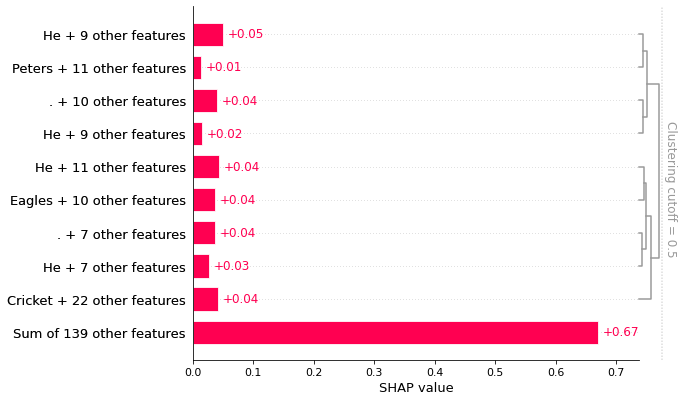

In [ ]:
shap.plots.bar(shap_values[0,:,'LABEL_0'])

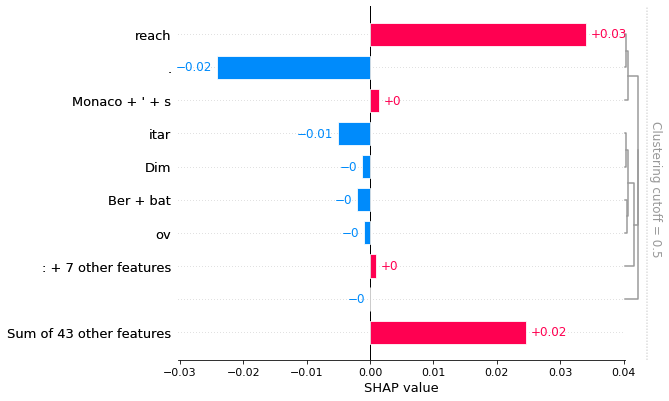

In [ ]:
shap.plots.bar(shap_values[1,:,'LABEL_1'])

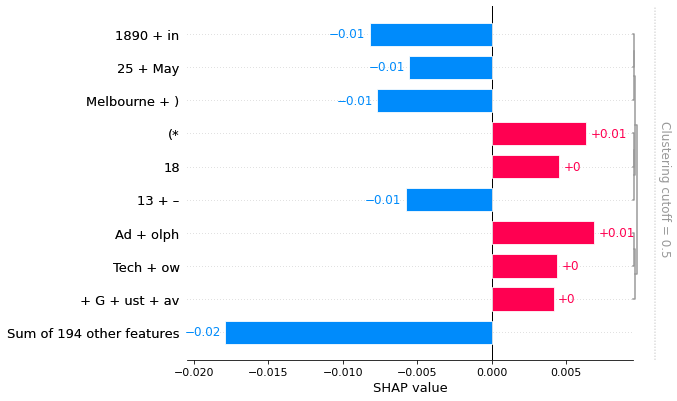

In [ ]:
shap.plots.bar(shap_values[2,:,'LABEL_1'])

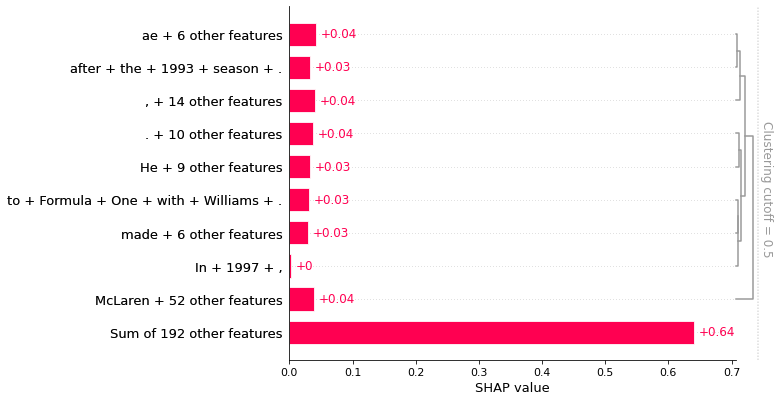

In [ ]:
shap.plots.bar(shap_values[3,:,'LABEL_0'])

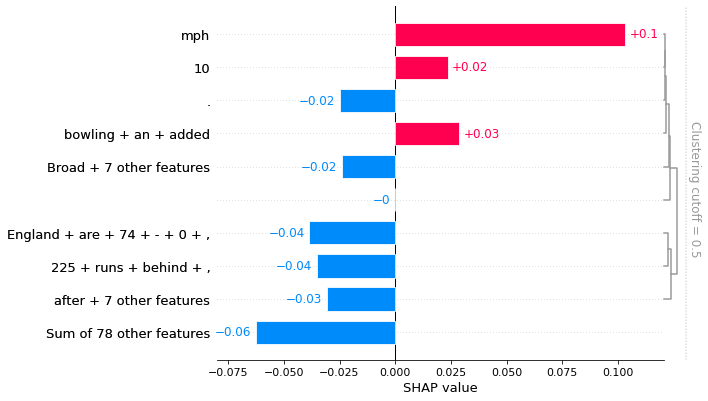

In [ ]:
shap.plots.bar(shap_values[4,:,'LABEL_1'])

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: id, text, __index_level_0__. If id, text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 16
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.697126030921936,
 'eval_accuracy': 0.50375,
 'eval_runtime': 9.6613,
 'eval_samples_per_second': 82.805,
 'eval_steps_per_second': 5.175}

## Finetuning

In [ ]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.4 MB/s eta 0:00:00


In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=encoded_dataset["train"].shard(index = 1, num_shards = 10), #train on 1/10 th of the dataset
    eval_dataset=encoded_dataset["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when in

In [ ]:
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

[I 2023-03-01 20:46:53,324] A new study created in memory with name: no-name-503da360-9df4-40bc-a85c-60ab6a4044b2
Trial: {'learning_rate': 1.2979881332007866e-05, 'num_train_epochs': 4, 'seed': 11, 'per_device_train_batch_size': 4}
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.b

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: id, text, __index_level_0__. If id, text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-classification/run-0/checkpoint-80
Configuration saved in distilbert-base-uncased-finetuned-classification/run-0/checkpoint-80/config.json
Model weights saved in distilbert-base-uncased-finetuned-classification/run-0/checkpoint-80/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-classification/run-0/checkpoint-80/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-classification/run-0/checkpoint-80/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finet

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: id, text, __index_level_0__. If id, text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-classification/run-1/checkpoint-10
Configuration saved in distilbert-base-uncased-finetuned-classification/run-1/checkpoint-10/config.json
Model weights saved in distilbert-base-uncased-finetuned-classification/run-1/checkpoint-10/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-classification/run-1/checkpoint-10/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-classification/run-1/checkpoint-10/special_tokens_map.json
The following columns in the evaluation set don't have a cor

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: id, text, __index_level_0__. If id, text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-classification/run-2/checkpoint-10
Configuration saved in distilbert-base-uncased-finetuned-classification/run-2/checkpoint-10/config.json
Model weights saved in distilbert-base-uncased-finetuned-classification/run-2/checkpoint-10/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-classification/run-2/checkpoint-10/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-classification/run-2/checkpoint-10/special_tokens_map.json
The following columns in the evaluation set don't have a cor

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: id, text, __index_level_0__. If id, text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-classification/run-3/checkpoint-80
Configuration saved in distilbert-base-uncased-finetuned-classification/run-3/checkpoint-80/config.json
Model weights saved in distilbert-base-uncased-finetuned-classification/run-3/checkpoint-80/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-classification/run-3/checkpoint-80/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-classification/run-3/checkpoint-80/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finet

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: id, text, __index_level_0__. If id, text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-classification/run-4/checkpoint-10
Configuration saved in distilbert-base-uncased-finetuned-classification/run-4/checkpoint-10/config.json
Model weights saved in distilbert-base-uncased-finetuned-classification/run-4/checkpoint-10/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-classification/run-4/checkpoint-10/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-classification/run-4/checkpoint-10/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finet

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: id, text, __index_level_0__. If id, text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 16
[I 2023-03-01 20:56:52,606] Trial 5 pruned. 
Trial: {'learning_rate': 3.5156394814605397e-06, 'num_train_epochs': 4, 'seed': 23, 'per_device_train_batch_size': 16}
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: id, text, __index_level_0__. If id, text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-classification/run-6/checkpoint-20
Configuration saved in distilbert-base-uncased-finetuned-classification/run-6/checkpoint-20/config.json
Model weights saved in distilbert-base-uncased-finetuned-classification/run-6/checkpoint-20/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-classification/run-6/checkpoint-20/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-classification/run-6/checkpoint-20/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finet

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: id, text, __index_level_0__. If id, text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-classification/run-7/checkpoint-20
Configuration saved in distilbert-base-uncased-finetuned-classification/run-7/checkpoint-20/config.json
Model weights saved in distilbert-base-uncased-finetuned-classification/run-7/checkpoint-20/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-classification/run-7/checkpoint-20/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-classification/run-7/checkpoint-20/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finet

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: id, text, __index_level_0__. If id, text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-classification/run-8/checkpoint-10
Configuration saved in distilbert-base-uncased-finetuned-classification/run-8/checkpoint-10/config.json
Model weights saved in distilbert-base-uncased-finetuned-classification/run-8/checkpoint-10/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-classification/run-8/checkpoint-10/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-classification/run-8/checkpoint-10/special_tokens_map.json
The following columns in the evaluation set don't have a cor

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: id, text, __index_level_0__. If id, text, __index_level_0__ are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-classification/run-9/checkpoint-5
Configuration saved in distilbert-base-uncased-finetuned-classification/run-9/checkpoint-5/config.json
Model weights saved in distilbert-base-uncased-finetuned-classification/run-9/checkpoint-5/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-classification/run-9/checkpoint-5/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-classification/run-9/checkpoint-5/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-

In [ ]:
best_run

BestRun(run_id='3', objective=0.74, hyperparameters={'learning_rate': 5.894711771413252e-05, 'num_train_epochs': 5, 'seed': 30, 'per_device_train_batch_size': 4})

## Baseline Prediction

In [ ]:
# Use logistic regression to predict the class
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(training_set['text'])
# b = np.array([training_set['text'].apply(len)])
# X[:,-1] = b

c:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
clf = LogisticRegression()
clf.fit(X, training_set['label'])
X_test = vectorizer.transform(test_set['text'])
predictions = clf.predict(X_test)

In [ ]:
predictions

array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
# all_zero_predictions = np.zeros(len(predictions))
# all_zero_predictions = all_zero_predictions.astype(int)
# all_zero_predictions

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(training_set['text'])
clf = RandomForestClassifier()
clf.fit(X, training_set['label'])
X_test = vectorizer.transform(test_set['text'])
predictions = clf.predict(X_test)

## Submission

In [ ]:
def submit(my_pred, name = 'last_submission'):
  # Write predictions to a file
  with open(name + ".csv", "w") as pred:
      csv_out = csv.writer(pred)
      csv_out.writerow(['id','label'])
      for i, row in enumerate(my_pred):
          csv_out.writerow([i, row])

In [ ]:
# Get the file on the left folder icon
submit(my_pred, name = 'roberta_submission_v2')